<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

print(tf.__version__)

2.8.2


## Dataset

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology

https://archive.ics.uci.edu/ml/datasets/Solar+Flare

In [52]:
#!wget -O COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt"

--2022-07-12 01:04:57--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt’

COM_PowerSpect_CMB-     [     <=>            ] 200.83K   214KB/s    in 0.9s    

2022-07-12 01:04:59 (214 KB/s) - ‘COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt’ saved [205647]



In [3]:
!wget "https://raw.githubusercontent.com/barauna-lo/Neurocomputing/main/COM_PowerSpect_CMB-TT-full_R3.01.txt"


--2022-07-12 01:26:27--  https://raw.githubusercontent.com/barauna-lo/Neurocomputing/main/COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170476 (166K) [text/plain]
Saving to: ‘COM_PowerSpect_CMB-TT-full_R3.01.txt’

COM_PowerSpect_CMB- 100%[===================>] 166.48K  --.-KB/s    in 0.004s  

2022-07-12 01:26:27 (44.5 MB/s) - ‘COM_PowerSpect_CMB-TT-full_R3.01.txt’ saved [170476/170476]



In [4]:
df = pd.read_fwf('COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["l", "Dl", "min_error", "max_error"]

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

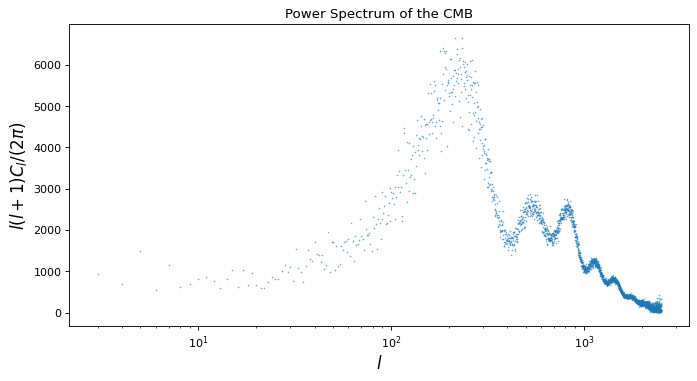

In [9]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.1)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.plot()


751
1755


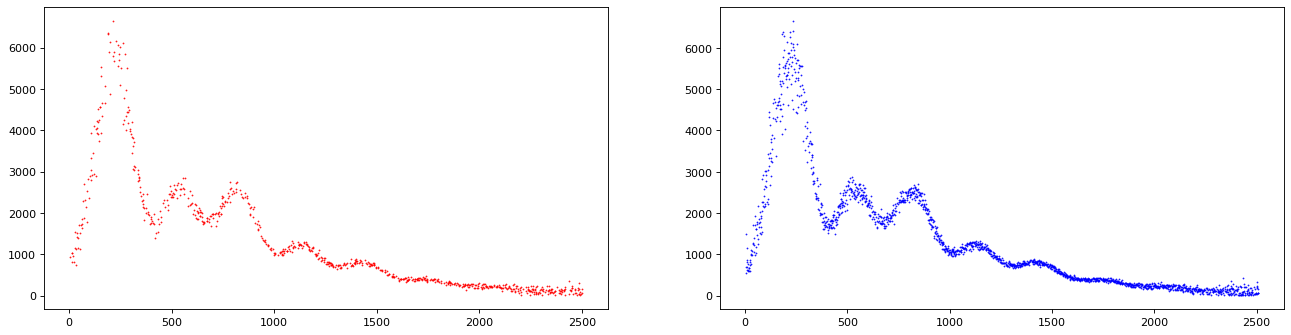

In [24]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
print(len(x_train))
print(len(x_test))
figure(figsize=(20,5),dpi=80)
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.show()


## Modelo 1

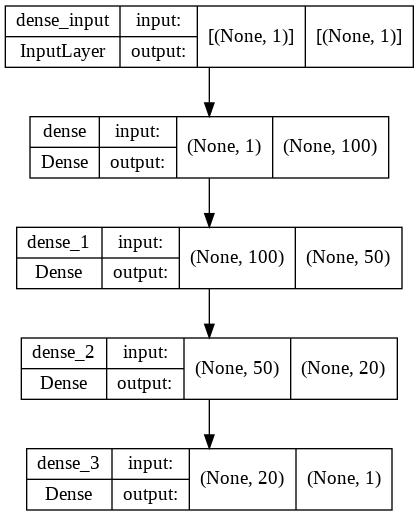

In [12]:
fl2 = 0.0
drop = 0.2

# model = keras.Sequential()
# model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(keras.layers.Dense(units=1, activation="linear"))

model = keras.Sequential()
model.add(keras.layers.Dense(units=100, input_shape=[1], activation="tanh"))
model.add(keras.layers.Dense(units=50, activation="tanh"))
model.add(keras.layers.Dense(units=20, activation="tanh"))
model.add(keras.layers.Dense(units=1, activation="linear"))


sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
adam = tf.keras.optimizers.Adam()

model.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model, show_shapes=True)


## Treino

In [13]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history = model.fit(x_train, y_train, epochs=3000, batch_size=10, 
                    validation_split=0.2, 
                    verbose=False)#, 
                    #callbacks=[early])

# print("Network parameters: {}".format(model.get_weights()))



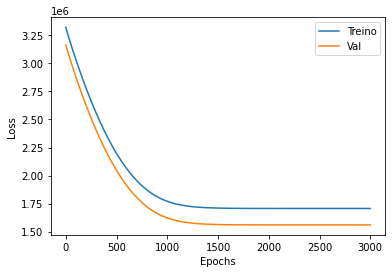

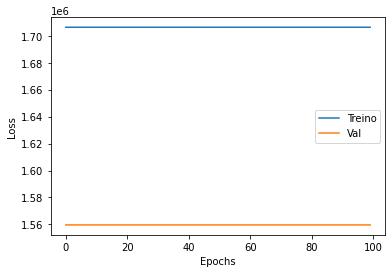

In [14]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Treino")
plt.plot(history.history['val_loss'], label="Val")
plt.legend()
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'][-100:], label="Treino")
plt.plot(history.history['val_loss'][-100:], label="Val")
plt.legend()
plt.show()



# Avaliação (teste)

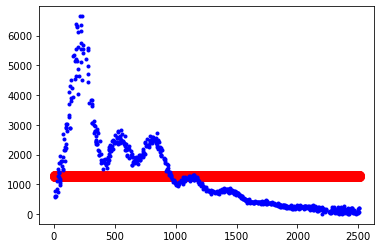

In [15]:
y_rest = model.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=20 ,color='red')
plt.plot(x_train, y_train, '.', color='blue')
plt.show()


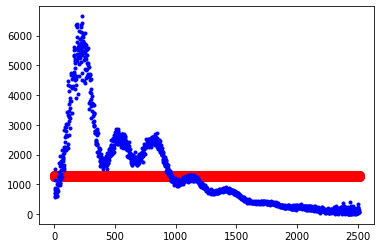

55/55 [==============================] - 0s 1ms/step - loss: 1828976.5000 - mean_absolute_error: 1021.6118


In [25]:
y_res = model.predict(x_test)
plt.plot(x_test, y_res, '.', markersize=20, color='red')
plt.plot(x_test, y_test, '.', color='blue')
plt.show()

test_loss = model.evaluate(x_test, y_test)

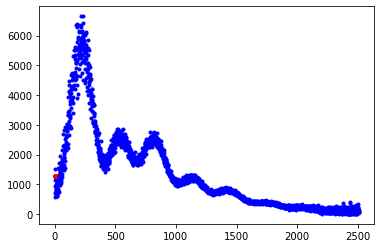

In [26]:
xn = np.arange(0, 8.0*math.pi,0.1)
yn = model.predict(xn)
plt.plot(xn, yn, '.', color='red')
plt.plot(x, y, '.', color='blue')
plt.show()



In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 0.5340995192527771
Test metric: 0.5007112622261047


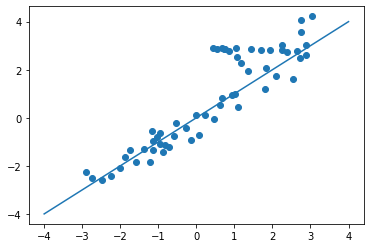

In [ ]:
plt.scatter(y_test, y_res)
plt.plot([-4,4], [-4,4])
plt.show()

## Keras Functional